# Importing Packages

In [64]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("fivethirtyeight")

# import modules for preprocessing
from sklearn import tree
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE, SelectKBest, f_regression, RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler,OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import validation_curve, GridSearchCV,RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def rmse(y, y_pred):
    return round(np.sqrt(mean_squared_error(y, y_pred)), 2)
def bias(y, y_pred):
	return round(np.mean(y_pred - y), 2)
def variance(y_pred):
	return np.mean([yi**2 for yi in y_pred]) - np.mean(y_pred)**2

# import module for object serialization
import pickle



# Feature Engineering Continued

## One-Hot Encoding/Dummy Variables

Creating dummy variables allow us to input categorical variables into the Machine Learning models, which require that all input data be numerical. Here, they are numerical, but take on discrete numerical values, so we consider them as categorical.  Dummy variables only take on the value of 0 or 1 for the absence or presence of some aspect of the category that is expected to effect the outcome. We did not create polynomial and interaction features for dummy variables since the values are only 0 and 1.

In [2]:
df = pd.read_csv('data/modeling.csv')

In [3]:
# Get index of the columns
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'sale_age', 'age', 'renovated',
       'basement', 'viewed'],
      dtype='object')

In [4]:
# Grab indices of columns for creating dummy variables and create dataframe with dummy variables
dum_feat = df[['bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode']]
dum_index = dum_feat.columns
# To prevent what they call the dummy variable trap (related to multicollinearity), drop one of the dummy variable, as well as  the original categorical variable used in creating the dummy variables
df_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['bdr', 'bth', 'flr', 'cnd', 'grd', 'zip'])
df_dum.head()

,bdr_1,bdr_2,bdr_3,bdr_4,bdr_5,bdr_6,bdr_7,bdr_8,bdr_9,bdr_10,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Polynomial and Interaction Features

Polynomial features are created by raising our exisitng features by some exponent, generally not greater than 3 or 4.  Adding polynomial features helps the regression models to recognize nonlinear patterns. For instance, age is related to price in more of a parabolic function due to the higher premium placed on brand new constructions vs. vintage or historic homes, which are on opposite ends of the age spectrum.

Interaction features, however, are represented by one variable or feature multipled by another feature. The idea here is that feature A's effect on C depend on the differing values of feature B.  Let's say C is plant growth, feature A is the amount of bacteria and feature B is the amount of sunlight.  In low amounts of sunlight, a high amount of bacteria in the soil creates tall plants, let's say, but in high amounts of sunlight, that same amount of bacteria creates short plants.  Only an interaction feature would be able to express that relationship.

In [5]:
# Grab columns for polynominal and interaction features from the original dataframe without dummy variables
poly_feat = df.drop(['price', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode'], axis=1)
y = df['price']
# Use PolynomialFeatures to create binomial and interaction features
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(poly_feat)
poly_columns = poly.get_feature_names(poly_feat.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
# Concatenating two dataframes together for input into linear regression model
X = pd.concat([df_poly, df_dum], axis=1)
X.head()

,sqft_living,sqft_lot,waterfront,sqft_above,lat,long,sqft_living15,sqft_lot15,sale_age,age,...,zip_98146,zip_98148,zip_98155,zip_98166,zip_98168,zip_98177,zip_98178,zip_98188,zip_98198,zip_98199
0,2070.0,8893.0,0.0,2070.0,47.4388,-122.162,2390.0,7700.0,28.0,28.0,...,0,0,0,0,0,0,0,0,0,0
1,2900.0,6730.0,0.0,1830.0,47.6784,-122.285,2370.0,6283.0,37.0,37.0,...,0,0,0,0,0,0,0,0,0,0
2,3770.0,10893.0,0.0,3770.0,47.5646,-122.129,3710.0,9685.0,17.0,17.0,...,0,0,0,0,0,0,0,0,0,0
3,4560.0,14608.0,0.0,4560.0,47.6995,-122.228,4050.0,14226.0,25.0,25.0,...,0,0,0,0,0,0,0,0,0,0
4,2550.0,5376.0,0.0,2550.0,47.6647,-122.083,2250.0,4050.0,10.0,10.0,...,0,0,0,0,0,0,0,0,0,0


# Modeling Process

There are several techniques we could use to prepare a linear regression model, including taking it to pen and paper to calculate means, standard deviations, correlations, and covariance.  Here we employ OLS method or ordinary least squares method.

R^2 or the coefficient of determination is a measure to assess the goodness of fit of a regression model:

$$ R^2 = 1 - \frac{SS_{RES}}{SS_{TOT}} = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \hat{y}_i)^2} $$

- The R-squared value is more specifically the amount of variance in the dependent variable that can be explained by the independent variables, also the covariance of X and Y (SSxy) divided by variance in X (SSxx).
- The intercept is the mean of the dependent variable when all the indepedent variables are zero. 
- The coefficients are estimates of the actual population parameters, where the increase

- R-values range from 0 to 1, and higher values of R^2 would be indicative of a good fit, but if the R^2 value is too high, that often can be indicative of over-fitting. 
- The model starts becoming attuned to fit the noise in the sample rather than reflecting the entire population, which decreases its capability to make precise predictions.
- 


In [6]:
# Use scikit-learn to instantiate a linear regression object and fit the model to the data
lm = LinearRegression().fit(X, y)
# We use the value of R_squared as an indication of the fit 
print('Intercept :', lm.intercept_)
print('R^2 Score : ', lm.score(X, y))
print('Coefficients :', lm.coef_)

Intercept : -3804210354.986055
R^2 Score :  0.8797519008528518
Coefficients : [-1.49291857e+04  4.75406407e+01  3.94448372e+07 -2.59759303e+04
  1.41288975e+08 -7.81019356e+06 -1.04595256e+04  1.30273015e+02
 -2.10502368e+05 -2.04893173e+05 -1.45145314e+06  4.74925866e+06
 -1.22026469e+07 -8.88278973e-03 -3.61393976e-04  2.74244013e+02
  3.35891471e-02  1.57090682e+02 -2.24569896e+02  4.21863761e-02
 -1.12054506e-03 -3.60556721e+00  2.72893588e+00 -9.15059039e+01
 -1.99579299e+04 -2.06220885e+01 -4.00472469e-07  9.86384652e-01
  2.69431350e-04  2.10866494e-01  4.65852178e-01  9.97489500e-05
  1.02137081e-06  1.07714646e-02 -1.25576453e-02  9.76441460e-01
  1.88665614e-02  3.42700481e-02  4.02034066e+07 -7.51815051e+01
  1.10313822e+06  1.40637453e+06 -8.38103035e+01 -3.42388412e-01
 -4.81472988e+03  4.54658377e+03 -2.79998877e+05 -1.40183302e+05
  4.02034056e+07 -1.06802308e-02  9.18909824e+01 -1.36381598e+01
 -2.89016161e-02  9.72065143e-04  1.50038569e+00 -5.62201155e-01
 -1.15311459

## **Train-Test Split**

The train-test split is a technique for evaluating the performance of a machine learning algorithm, which can be used for classification or regression problems or any supervised learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model, the training dataset, and for the second subset, the test dataset, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values.  The objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

This is how we expect to use the model in practice. Namely, to fit it on available data with known inputs and outputs, then make predictions on new examples in the future where we do not have the expected output or target values.

The train-test procedure is appropriate when there is a sufficiently large dataset available. When the dataset available is small, we can consider using a k-fold cross-validation procedure to evaluate the model performance.

### Assessing Training Model Performance, Predicting on Testing Set, and Comparing Model Performance

As for what we use for regression metrics, 

1. MAE describes the typical magnitude of the residuals, where small MAE suggests that the model is good for prediction.
2. MSE is the square of the difference between actual and predicted values, and will always be larger than MAE.  The presence of outliers will contribute quadratically to the error such that large differences between actual and predicted values are punished to a greater degree.
3. RMSE is the square root of the variance of the residuals, which indicates the best absolute fit of the model to the data, having the same units as the target variable, where lower values indicates a better fit.  

RMSE is the most important criterion for fit when we are working within prediction models and is the metric we most often use to compare between the training and testing model performance.

In [7]:
X_tr, X_tt, y_tr, y_tt = train_test_split(X, y, random_state=42, test_size=0.2)
lm = LinearRegression().fit(X_tr, y_tr)
y_tr_pred = lm.predict(X_tr)
y_tt_pred = lm.predict(X_tt)
print('Training R^2 Score: ', round(r2_score(y_tr, y_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr, y_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr, y_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr, y_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr, y_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt, y_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt, y_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt, y_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt, y_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt, y_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred)))

Training R^2 Score:  0.8836
Training MAE:  79265.07
Training MSE:  1.6408e+10
Training RMSE:  128094.52
Training Bias:  0.0
Training Variance:  1.2469e+11

Testing R^2 Score:  0.8649
Testing MAE:  79461.47
Testing MSE:  1.7982e+10
Testing RMSE:  134097.92
Testing Bias:  -1796.49
Testing Variance:  1.1053e+11


**Initial thoughts:**

Comparing the training and testing RMSE, there is expected increase in RMSE from the training to the testing set.  The model still includes all the polynomial and interaction features, so it is definitely still overfit.


## Check for the Linear Regression assumptions


In [8]:
# this defines residuals as the sample estimate of the error for each observation
residuals = (y_tt - y_tt_pred)

In [9]:
# This checks for the normal distribution of the residuals or error term.  By satisfying this assumption, you are able to generate more reliable confidence and prediction intervals.
# plt.hist(residuals)
# plt.savefig('images/residuals.png')

<img src='images/residuals.png'>

In [10]:
# # We use residplot to check for heteroscedasticity, which is the case where the residuals have a non-constant variance
# sns.residplot(y_tt_pred, y_test, lowess=True, color='g')
# plt.savefig('images/residplot.png')

<img src='images/residplot.png'>

# Feature Selection

There are three types of feature selection methods:  filter, wrapper, and embedded.  Filtering methods, like K-Best, approach the problem by estimating the validities of features through statistical tests (i.e. correlation coefficient, information gain, chi-squared test, f-test) to assign scoring to each feature, which are subsequently ranked and selected.  Here K-Best uses the f-test (`f_regression`) to compare the least square errors between the two models and checks if the difference is significant and returns the top 20 features.

Filtering methods are computationally less expensive than wrapper methods since we are not training an actual model.

## KBest

In [11]:
# Instantiate SelectKBest object and fit training data where k is the number of features you want to select
kbest = SelectKBest(f_regression, k=20).fit(X_tr, y_tr)
sel_columns = X_tr.columns[kbest.get_support()]
rem_columns = X_tr.columns[~kbest.get_support()]
list(sel_columns)

['sqft_living',
 'sqft_above',
 'sqft_living15',
 'sqft_living^2',
 'sqft_living sqft_above',
 'sqft_living lat',
 'sqft_living long',
 'sqft_living sqft_living15',
 'sqft_living basement',
 'sqft_living viewed',
 'sqft_above^2',
 'sqft_above lat',
 'sqft_above long',
 'sqft_above sqft_living15',
 'sqft_above basement',
 'sqft_above viewed',
 'lat sqft_living15',
 'long sqft_living15',
 'sqft_living15^2',
 'sqft_living15 viewed']

In [12]:
# Instantiate linear regression object and fit the linear regression to the data
kb = LinearRegression().fit(X_tr[sel_columns], y_tr)
y_kb_tr_pred = kb.predict(X_tr[sel_columns])
y_kb_tt_pred = kb.predict(X_tt[sel_columns])

print('Training R^2 Score: ', round(r2_score(y_tr, y_kb_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr, y_kb_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr, y_kb_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr, y_kb_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr, y_kb_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_kb_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt, y_kb_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt, y_kb_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt, y_kb_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt, y_kb_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt, y_kb_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_kb_tt_pred)))

Training R^2 Score:  0.6877
Training MAE:  130573.33
Training MSE:  4.4014e+10
Training RMSE:  209795.48
Training Bias:  -0.0
Training Variance:  9.6902e+10

Testing R^2 Score:  0.6911
Testing MAE:  126932.94
Testing MSE:  4.1107e+10
Testing RMSE:  202748.99
Testing Bias:  -4699.59
Testing Variance:  8.2792e+10


## RFECV

Wrapper algorithms like RFECV returns a best set of features with an extensive greedy search, where different combinations are prepared, evaluated, and compared to other combinations.  Recursive Feature Elimination and Cross-Validation Selection begins with a model with the complete set of predictors and a score is assigned to each predictor, and the least important are removed.  The model is then rebuilt, and importance scores are computed again.  It is usually best practice to identify multicollinearity first, as it will select relevant and redundant features alike. 

In [13]:
lm = LinearRegression()
rfe = RFECV(estimator=lm, step=1, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
rfe.fit(X_tr, y_tr)
selected = X_tr.columns[rfe.support_]
print("Optimal number of features : %d" % rfe.n_features_)

Optimal number of features : 226


In [14]:
removed = X_tr.columns[~rfe.support_]
list(removed)

['sqft_living sqft_lot',
 'sqft_lot^2',
 'sqft_lot sqft_living15',
 'sqft_lot sqft_lot15',
 'sqft_lot15^2',
 'bth_7.5',
 'grd_3']

In [15]:
rfecv = LinearRegression().fit(X_tr[selected], y_tr)
y_tr_pred_rfe = rfecv.predict(X_tr[selected])
y_tt_pred_rfe = rfecv.predict(X_tt[selected])

print('Training R^2 Score: ', round(r2_score(y_tr, y_tr_pred_rfe), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr, y_tr_pred_rfe), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr, y_tr_pred_rfe)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr, y_tr_pred_rfe)), 2))
print('Training Bias: ', round(bias(y_tr, y_tr_pred_rfe), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred_rfe)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt, y_tt_pred_rfe), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt, y_tt_pred_rfe), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt, y_tt_pred_rfe)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt, y_tt_pred_rfe)), 2))
print('Testing Bias: ', round(bias(y_tt, y_tt_pred_rfe), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred_rfe)))


Training R^2 Score:  0.8842
Training MAE:  78848.97
Training MSE:  1.6312e+10
Training RMSE:  127719.34
Training Bias:  -0.0
Training Variance:  1.2460e+11

Testing R^2 Score:  0.8659
Testing MAE:  78660.89
Testing MSE:  1.7841e+10
Testing RMSE:  133569.89
Testing Bias:  -1884.29
Testing Variance:  1.1037e+11


# Second Run

In [17]:
y = df['price']
X = df.drop(columns=['price', 'sqft_lot15', 'sqft_above'], axis=1)
dum_feat = df[['bathrooms', 'condition', 'grade', 'zipcode']]
dum_index = dum_feat.columns
df_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['bth', 'cnd', 'grd', 'zip'])
poly_feat = df.drop(['price', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'zipcode'], axis=1)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_data = poly.fit_transform(poly_feat)
poly_columns = poly.get_feature_names(poly_feat.columns)
df_poly = pd.DataFrame(poly_data, columns=poly_columns)
X = pd.concat([df_poly, df_dum], axis=1)



In [20]:
X_tr2, X_tt2, y_tr2, y_tt2 = train_test_split(X, y, random_state=42, test_size=0.2)
lm2 = LinearRegression().fit(X_tr2, y_tr2)
y_tr_pred2 = lm2.predict(X_tr2)
y_tt_pred2 = lm2.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_tr_pred2), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_tr_pred2), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_tr_pred2)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_tr_pred2)), 2))
print('Training Bias: ', round(bias(y_tr2, y_tr_pred2), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred2)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_tt_pred2), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_tt_pred2), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_tt_pred2)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_tt_pred2)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_tt_pred2), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred2)))

Training R^2 Score:  0.8777
Training MAE:  81557.89
Training MSE:  1.7234e+10
Training RMSE:  131279.78
Training Bias:  0.0
Training Variance:  1.2502e+11

Testing R^2 Score:  0.8619
Testing MAE:  80672.56
Testing MSE:  1.8372e+10
Testing RMSE:  135544.37
Testing Bias:  -3839.86
Testing Variance:  1.0931e+11


## Ridge Regression

Embedded methods learn which features best contribute to the accuracy of the model while the model is being created, the most common being the regularization methods.  They are also called penalization methods that introduce additional constraints into the optimization of a predictive algorithm that bias the model toward lower complexity, i.e. fewer coefficients.

Ridge regression optimizes the RSS by adding a penalty equivalent to the square of the magnitude of the coefficients, while Lasso adds a penalty equivalent to the absolute value of the magnitude of the coefficients.

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_tr2)
X_test_scaled = ss.fit_transform(X_tt2)
X_tr2_sc = pd.DataFrame(X_train_scaled, columns=X_tr2.columns)
X_tt2_sc = pd.DataFrame(X_test_scaled, columns=X_tt2.columns)

In [21]:
ridge = Ridge(alpha=1).fit(X_tr2_sc, y_tr2)
y_ridge_tr = ridge.predict(X_tr2_sc)
y_ridge_tt = ridge.predict(X_tt2_sc)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_ridge_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_ridge_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_ridge_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_ridge_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_ridge_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_ridge_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_ridge_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_ridge_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_ridge_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_ridge_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_ridge_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_ridge_tt)))

Training R^2 Score:  0.8718
Training MAE:  82047.99
Training MSE:  1.8068e+10
Training RMSE:  134418.16
Training Bias:  0.0
Training Variance:  1.2268e+11

Testing R^2 Score:  0.8469
Testing MAE:  83370.5
Testing MSE:  2.0371e+10
Testing RMSE:  142728.44
Testing Bias:  9477.89
Testing Variance:  1.1872e+11


Optimal Alpha Value: 0


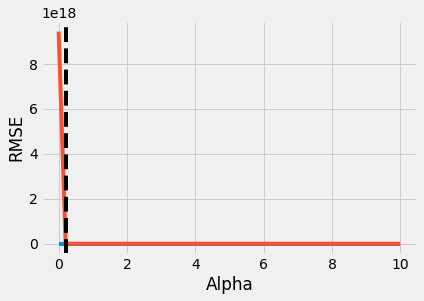

In [22]:
# tr_rmse_ridge = []
# tt_rmse_ridge = []
# alphas_ridge = []

# for alpha in np.linspace(0, 10, num=50):
#     ridge = Ridge(alpha=alpha)
#     ridge.fit(X_tr2_sc, y_tr2)
#     tr_pred = ridge.predict(X_tr2_sc)
#     tr_rmse_ridge.append(np.sqrt(mean_squared_error(y_tr2, tr_pred)))
#     tt_pred = ridge.predict(X_tt2_sc)
#     tt_rmse_ridge.append(np.sqrt(mean_squared_error(y_tt2, tt_pred)))
#     alphas_ridge.append(alpha)

# fig, ax = plt.subplots()
# ax.plot(alphas_ridge, tr_rmse_ridge, label="Train")
# ax.plot(alphas_ridge, tt_rmse_ridge, label="Test")
# ax.set_xlabel("Alpha")
# ax.set_ylabel("RMSE")
# optimal_alpha = alphas_ridge[np.argmin(tt_rmse_ridge)]
# ax.axvline(optimal_alpha, color="black", linestyle="--")
# print(f'Optimal Alpha Value: {int(optimal_alpha)}')
# plt.savefig('images/optimal_ridge.png')

# Optimal Alpha Value: 0

<img src="images/optimal_ridge.png">

In [23]:
ridge = Ridge(alpha=0.1, normalize=False)
ridge.fit(X_tr2_sc, y_tr2)
y_best_ridge_tr = ridge.predict(X_tr2_sc)
y_best_ridge_tt = ridge.predict(X_tt2_sc)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_best_ridge_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_best_ridge_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_best_ridge_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_best_ridge_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_best_ridge_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_best_ridge_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_best_ridge_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_best_ridge_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_best_ridge_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_best_ridge_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_best_ridge_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_best_ridge_tt)))

Training R^2 Score:  0.8753
Training MAE:  80639.73
Training MSE:  1.7578e+10
Training RMSE:  132583.55
Training Bias:  0.0
Training Variance:  1.2289e+11

Testing R^2 Score:  0.8501
Testing MAE:  82336.93
Testing MSE:  1.9944e+10
Testing RMSE:  141224.64
Testing Bias:  9477.89
Testing Variance:  1.1990e+11


In [72]:
top_feat_ridge = pd.DataFrame(np.abs(ridge.coef_), index=np.array(X_tr2_sc.columns), columns=['importance']).sort_values('importance', ascending=False)
top_feat_ridge.head(20)

,importance
sqft_living lat,2.220100e+06
sqft_living,2.115275e+06
sqft_above,2.043254e+06
sqft_above lat,2.036547e+06
waterfront lat,1.848757e+06
sqft_living15,1.501177e+06
lat viewed,1.336832e+06
lat sqft_living15,1.305806e+06
waterfront long,1.152773e+06
viewed,7.884498e+05


In [90]:
top_feat_ridge.tail(20)

,importance
zip_98032,1386.128575
bth_5.75,1121.457783
bth_0.75,1109.891950
renovated viewed,1025.658378
waterfront sqft_lot15,906.471214
sqft_lot15 age,693.260132
zip_98092,691.358386
zip_98148,683.996492
zip_98070,663.187248
zip_98198,550.695936


In [ ]:
fig, ax = plt.subplots(figsize=(25, 10))
sns.boxplot(importance, data=tfr)
sns.stripplot(importance, color='black', alpha=0.3, data=tfr)

## Lasso Regression

In [25]:
lasso = Lasso(alpha=1).fit(X_tr2_sc, y_tr2)
y_lasso_tr = lasso.predict(X_tr2_sc)
y_lasso_tt = lasso.predict(X_tt2_sc)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_lasso_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_lasso_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_lasso_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_lasso_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_lasso_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_lasso_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_lasso_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_lasso_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_lasso_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_lasso_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_lasso_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_lasso_tt)))

Training R^2 Score:  0.8707
Training MAE:  82568.84
Training MSE:  1.8227e+10
Training RMSE:  135006.92
Training Bias:  0.0
Training Variance:  1.2267e+11

Testing R^2 Score:  0.8469
Testing MAE:  83854.94
Testing MSE:  2.0372e+10
Testing RMSE:  142731.09
Testing Bias:  9477.89
Testing Variance:  1.1908e+11


Optimal Alpha Value: 400


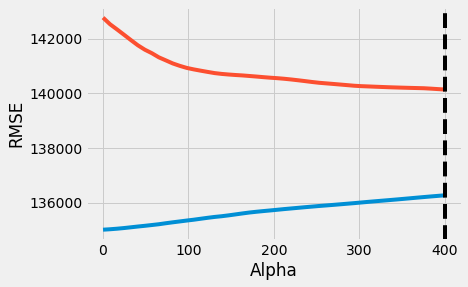

In [27]:
# tr_rmse_lasso = []
# tt_rmse_lasso = []
# alphas_lasso = []

# for alpha in np.linspace(0, 400, num=50):
#     lasso = Lasso(alpha=alpha)
#     lasso.fit(X_tr2_sc, y_tr2)
#     tr_pred = lasso.predict(X_tr2_sc)
#     tr_rmse_lasso.append(np.sqrt(mean_squared_error(y_tr2, tr_pred)))
#     tt_pred = lasso.predict(X_tt2_sc)
#     tt_rmse_lasso.append(np.sqrt(mean_squared_error(y_tt2, tt_pred)))
#     alphas_lasso.append(alpha)

# fig, ax = plt.subplots()
# ax.plot(alphas_lasso, tr_rmse_lasso, label="Train")
# ax.plot(alphas_lasso, tt_rmse_lasso, label="Test")
# ax.set_xlabel("Alpha")
# ax.set_ylabel("RMSE")
# optimal_alpha = alphas_lasso[np.argmin(tt_rmse_lasso)]
# ax.axvline(optimal_alpha, color="black", linestyle="--")
# print(f'Optimal Alpha Value: {int(optimal_alpha)}')
# plt.savefig('images/optimal_lasso.png')

# Optimal Alpha Value: 400

<img src="images/optimal_lasso.png">

In [28]:
lasso = Lasso(alpha=400, normalize=False)
lasso.fit(X_tr2_sc, y_tr2)
y_best_lasso_tr = lasso.predict(X_tr2_sc)
y_best_lasso_tt = lasso.predict(X_tt2_sc)

print('Training R^2 Score: ', round(r2_score(y_tr2, y_best_lasso_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_best_lasso_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_best_lasso_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_best_lasso_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, y_best_lasso_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_best_lasso_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_best_lasso_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_best_lasso_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_best_lasso_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_best_lasso_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_best_lasso_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_best_lasso_tt)))

Training R^2 Score:  0.8682
Training MAE:  82700.69
Training MSE:  1.8568e+10
Training RMSE:  136264.04
Training Bias:  -0.0
Training Variance:  1.2076e+11

Testing R^2 Score:  0.8524
Testing MAE:  82430.17
Testing MSE:  1.9638e+10
Testing RMSE:  140134.98
Testing Bias:  9477.89
Testing Variance:  1.1779e+11


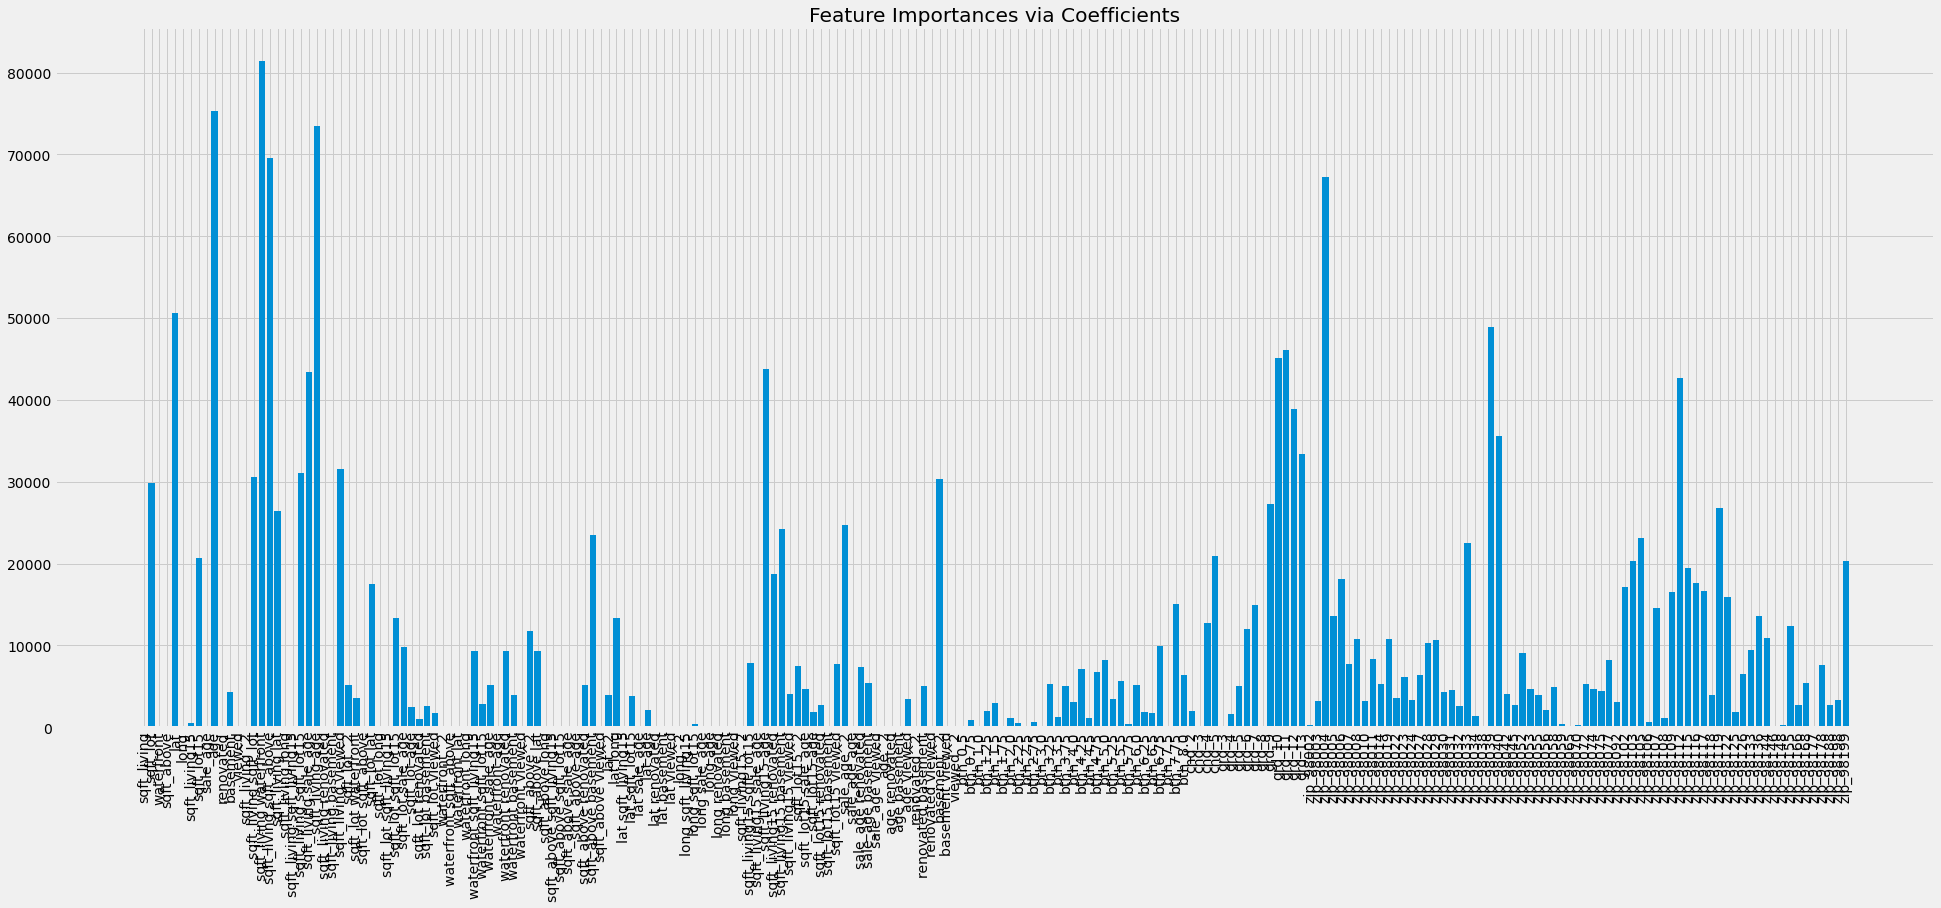

In [29]:
importance = np.abs(lasso.coef_)
names = np.array(X_tr2_sc.columns)
fig, ax = plt.subplots(figsize=(30, 12))
plt.bar(height=importance, x=names)
plt.xticks(rotation = 90)
plt.title("Feature Importances via Coefficients")
plt.show()


In [73]:
top_feat_lasso = pd.DataFrame(np.abs(lasso.coef_),
                              index=np.array(X_tr2_sc.columns),
                              columns=['importance']).sort_values('importance', ascending=False)
top_feat_lasso.head(20)

,importance
sqft_living waterfront,81452.296094
age,75358.531300
sqft_living age,73426.506540
sqft_living sqft_above,69579.176108
zip_98004,67290.814137
lat,50622.659387
zip_98039,48878.531394
grd_11,46103.870450
grd_10,45109.400635
sqft_living15 age,43767.160362


In [95]:
lasso_zero = top_feat_lasso.loc[top_feat_lasso.importance == 0]
lasso_zero.index

Index(['grd_3', 'waterfront^2', 'sqft_lot sqft_living15', 'waterfront lat',
       'waterfront long', 'bth_1.75', 'waterfront age',
       'waterfront sqft_above', 'sqft_living basement', 'sqft_lot long',
       'sqft_lot sqft_above', 'sqft_living renovated',
       'sqft_living sqft_living15', 'sqft_living long', 'bth_2.5',
       'sqft_living^2', 'viewed', 'renovated', 'sale_age', 'zip_98146', 'long',
       'zip_98177', 'sqft_above', 'waterfront', 'zip_98065', 'sqft_above long',
       'waterfront viewed', 'long age', 'long basement', 'long viewed',
       'sqft_living15^2', 'sqft_living15 sale_age', 'bth_0.5', 'viewed^2',
       'sqft_lot15 basement', 'sale_age age', 'sale_age viewed', 'age^2',
       'age renovated', 'age basement', 'grd_8', 'renovated^2',
       'renovated viewed', 'long renovated', 'long sale_age', 'bth_7.5',
       'long sqft_living15', 'basement viewed', 'sqft_above sqft_living15',
       'sqft_above sqft_lot15', 'bth_1.0', 'sqft_above sale_age',
       'sqft_

## Lasso Regression with AIC and BIC

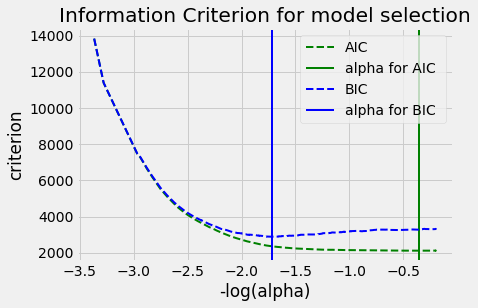

In [31]:
model_bic = LassoLarsIC(criterion="bic")
model_bic.fit(X_tr2_sc, y_tr2)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion="aic")
model_aic.fit(X_tr2_sc, y_tr2)
alpha_aic_ = model_aic.alpha_

def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color, linewidth=2, label=name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=2, label='alpha for %s ' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'green')
plot_ic_criterion(model_bic, 'BIC', 'blue')
plt.legend()
plt.title("Information Criterion for model selection");

In [32]:
aic_lasso = Lasso(alpha=model_aic.alpha_).fit(X_tr2_sc, y_tr2)
aic_tr_pred = aic_lasso.predict(X_tr2_sc)
aic_tt_pred = aic_lasso.predict(X_tt2_sc)

print('Training R^2 Score: ', round(r2_score(y_tr2, aic_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, aic_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, aic_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, aic_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr2, aic_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(aic_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, aic_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, aic_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, aic_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, aic_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, aic_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(aic_tt_pred)))

Training R^2 Score:  0.8707
Training MAE:  82566.96
Training MSE:  1.8227e+10
Training RMSE:  135009.2
Training Bias:  0.0
Training Variance:  1.2267e+11

Testing R^2 Score:  0.847
Testing MAE:  83827.52
Testing MSE:  2.0361e+10
Testing RMSE:  142691.23
Testing Bias:  9477.89
Testing Variance:  1.1906e+11


In [33]:
bic_lasso = Lasso(alpha=model_bic.alpha_).fit(X_tr2_sc, y_tr2)
bic_tr_pred = bic_lasso.predict(X_tr2_sc)
bic_tt_pred = bic_lasso.predict(X_tt2_sc)

print('Training R^2 Score: ', round(r2_score(y_tr2, bic_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, bic_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, bic_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, bic_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr2, bic_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(bic_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, bic_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, bic_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, bic_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, bic_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, bic_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(bic_tt_pred)))

Training R^2 Score:  0.8704
Training MAE:  82538.73
Training MSE:  1.8267e+10
Training RMSE:  135157.01
Training Bias:  0.0
Training Variance:  1.2238e+11

Testing R^2 Score:  0.8494
Testing MAE:  83271.4
Testing MSE:  2.0033e+10
Testing RMSE:  141539.03
Testing Bias:  9477.89
Testing Variance:  1.1913e+11


## Decision Tree Regressor with GridSearchCV and Pipeline

In [34]:
dtm = DecisionTreeRegressor(random_state=42).fit(X_tr2, y_tr2)
y_tr_pred3 = dtm.predict(X_tr2) 
y_tt_pred3 = dtm.predict(X_tt2)
print('Training R^2 Score: ', round(r2_score(y_tr2, y_tr_pred3), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, y_tr_pred3), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, y_tr_pred3)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, y_tr_pred3)), 2))
print('Training Bias: ', round(bias(y_tr2, y_tr_pred3), 2))
print('Training Variance: ', "{:.4e}".format(variance(y_tr_pred3)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, y_tt_pred3), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, y_tt_pred3), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, y_tt_pred3)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, y_tt_pred3)), 2))
print('Testing Bias: ', round(bias(y_tt2, y_tt_pred3), 2))
print('Testing Variance: ', "{:.4e}".format(variance(y_tt_pred3)))

Training R^2 Score:  0.9999
Training MAE:  169.94
Training MSE:  1.4119e+07
Training RMSE:  3757.56
Training Bias:  0.0
Training Variance:  1.4090e+11

Testing R^2 Score:  0.7651
Testing MAE:  100066.3
Testing MSE:  3.1249e+10
Testing RMSE:  176773.42
Testing Bias:  2667.88
Testing Variance:  1.3348e+11


In [36]:
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
pipe_tree = make_pipeline(tree.DecisionTreeRegressor(random_state=1))
dtm = DecisionTreeRegressor()
param_grid = [{
               'decisiontreeregressor__max_depth': [1, 2, 5, 10, 15, 20],
               'decisiontreeregressor__min_samples_leaf': [1, 5, 10, 20, 50],
               'decisiontreeregressor__max_leaf_nodes': [5, 10, 20, 50, 100],
               'decisiontreeregressor__min_samples_split': [5, 10, 20, 40]
             }]
gs = GridSearchCV(pipe_tree, param_grid=param_grid, cv=10, scoring=rmse_scorer, verbose=1)
gs.fit(X_tr2, y_tr2)
print(f"Training Score: {gs.best_score_}")
print(gs.best_estimator_)

# Fitting 10 folds for each of 600 candidates, totalling 6000 fits
# Training Score: -175078.03997151004
# Pipeline(steps=[('decisiontreeregressor',
#                  DecisionTreeRegressor(max_depth=10, max_leaf_nodes=100,
#                                        min_samples_split=40, random_state=1))])

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Training Score: -175078.03997151004
Pipeline(steps=[('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=10, max_leaf_nodes=100,
                                       min_samples_split=40, random_state=1))])


In [37]:
gs_model = gs.best_estimator_
gs_model.fit(X_tr2, y_tr2)
gs_tr_pred = gs_model.predict(X_tr2)
gs_tt_pred = gs_model.predict(X_tt2) 

print('Training R^2 Score: ', round(r2_score(y_tr2, gs_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, gs_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, gs_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, gs_tr_pred)), 2))
print('Training Bias: ', round(bias(y_tr2, gs_tr_pred), 2))
print('Training Variance: ', "{:.4e}".format(variance(gs_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, gs_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, gs_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, gs_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, gs_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, gs_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(gs_tt_pred)))

# Training R^2 Score:  0.8579
# Training MAE:  88207.83
# Training MSE:  2.0018e+10
# Training RMSE:  141486.22
# Training Bias:  0.0
# Training Variance:  1.2090e+11

# Testing R^2 Score:  0.7933
# Testing MAE:  95884.01
# Testing MSE:  2.7501e+10
# Testing RMSE:  165834.58
# Testing Bias:  -1342.05
# Testing Variance:  1.0614e+11

Training R^2 Score:  0.8579
Training MAE:  88207.83
Training MSE:  2.0018e+10
Training RMSE:  141486.22
Training Bias:  0.0
Training Variance:  1.2090e+11

Testing R^2 Score:  0.7933
Testing MAE:  95884.01
Testing MSE:  2.7501e+10
Testing RMSE:  165834.58
Testing Bias:  -1342.05
Testing Variance:  1.0614e+11


In [38]:
dtr = DecisionTreeRegressor(max_depth=10, max_leaf_nodes=100,
                            min_samples_leaf=5,
                            min_samples_split=40,
                            random_state=1).fit(X_tr2, y_tr2)

In [74]:
top_feat_dt = pd.DataFrame(dtr.feature_importances_,
                           index=X_tr2.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
top_feat_dt.head(20)

,importance
sqft_living lat,0.475641
lat^2,0.160390
sqft_living sqft_living15,0.117406
sqft_living basement,0.051939
long,0.031739
lat,0.025609
long^2,0.023008
sqft_living15 age,0.013337
sqft_above sqft_living15,0.013225
sqft_above sqft_lot15,0.010962


In [98]:
dt_zero = top_feat_dt.loc[top_feat_dt.importance == 0]
dt_zero.index.tolist()

['bth_6.5',
 'zip_98014',
 'zip_98032',
 'bth_6.0',
 'zip_98031',
 'bth_7.5',
 'bth_6.75',
 'zip_98029',
 'zip_98028',
 'zip_98022',
 'zip_98023',
 'zip_98024',
 'zip_98027',
 'zip_98030',
 'bth_6.25',
 'zip_98019',
 'bth_8.0',
 'zip_98011',
 'zip_98010',
 'grd_9',
 'grd_5',
 'grd_4',
 'grd_3',
 'zip_98033',
 'cnd_5',
 'cnd_4',
 'grd_13',
 'cnd_3',
 'zip_98002',
 'zip_98003',
 'cnd_2',
 'zip_98005',
 'zip_98006',
 'zip_98007',
 'zip_98008',
 'bth_7.75',
 'sqft_living',
 'zip_98059',
 'zip_98034',
 'zip_98136',
 'zip_98115',
 'zip_98116',
 'zip_98117',
 'zip_98118',
 'zip_98119',
 'zip_98122',
 'zip_98125',
 'zip_98126',
 'zip_98133',
 'zip_98144',
 'zip_98108',
 'zip_98146',
 'zip_98148',
 'zip_98155',
 'zip_98166',
 'zip_98168',
 'zip_98177',
 'zip_98178',
 'zip_98188',
 'zip_98198',
 'zip_98109',
 'zip_98107',
 'zip_98038',
 'bth_5.5',
 'zip_98039',
 'zip_98040',
 'zip_98042',
 'zip_98045',
 'zip_98052',
 'zip_98053',
 'zip_98055',
 'zip_98056',
 'zip_98058',
 'zip_98065',
 'zip_9810

## Random Forest Regressor with RandomSearchCV and GridSearchCV

In [76]:
rf = RandomForestRegressor(n_estimators=100, 
                           max_features="auto", 
                           max_depth=100, 
                           min_samples_leaf=4, 
                           min_samples_split=10, 
                           random_state=1).fit(X_tr2, y_tr2)
rf_tr_pred = rf.predict(X_tr2)
rf_tt_pred = rf.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, rf_tr_pred), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, rf_tr_pred), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, rf_tr_pred)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, rf_tr_pred)), 2))
print('Training Bias: ', bias(y_tr2, rf_tr_pred))
print('Training Variance: ', "{:.4e}".format(variance(rf_tr_pred)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, rf_tt_pred), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, rf_tt_pred), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, rf_tt_pred)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, rf_tt_pred)), 2))
print('Testing Bias: ', round(bias(y_tt2, rf_tt_pred), 2))
print('Testing Variance: ', "{:.4e}".format(variance(rf_tt_pred)))

Training R^2 Score:  0.9458
Training MAE:  42564.3
Training MSE:  7.6441e+09
Training RMSE:  87430.82
Training Bias:  190.05
Training Variance:  1.1999e+11

Testing R^2 Score:  0.8705
Testing MAE:  71651.21
Testing MSE:  1.7237e+10
Testing RMSE:  131289.66
Testing Bias:  -1104.78
Testing Variance:  1.0170e+11


In [77]:
top_feat_rf = pd.DataFrame(rf.feature_importances_,
                           index=X_tr2.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
top_feat_rf.head(20)

,importance
sqft_living lat,0.307188
sqft_living sqft_living15,0.155893
lat^2,0.075278
lat,0.070771
sqft_living long,0.049169
lat long,0.028410
long^2,0.022321
long,0.021555
sqft_living basement,0.021085
sqft_living viewed,0.020610


In [99]:
top_feat_rf.value_counts()

importance
0.000000      17
0.000032       1
0.000050       1
0.000050       1
0.000050       1
              ..
0.000738       1
0.000688       1
0.000687       1
0.000684       1
0.000217       1
Length: 201, dtype: int64

In [55]:
random_grid = {'n_estimators': [20, 50, 100, 150, 200],
               'max_depth': [10, 20, 50, 100],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4]}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_tr2, y_tr2)
rf_random.best_params_


# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# {'n_estimators': 150,
#  'min_samples_split': 2,
#  'min_samples_leaf': 1,
#  'max_depth': 50}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 150,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 50}

In [62]:
best_random = rf_random.best_estimator_
rf_random_tr = rf_random.predict(X_tr2)
rf_random_tt = rf_random.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, rf_random_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, rf_random_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, rf_random_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, rf_random_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, rf_random_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(rf_random_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, rf_random_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, rf_random_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, rf_random_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, rf_random_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, rf_random_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(rf_random_tt)))

Training R^2 Score:  0.9801
Training MAE:  27058.29
Training MSE:  2.8010e+09
Training RMSE:  52924.47
Training Bias:  -14.82
Training Variance:  1.2696e+11

Testing R^2 Score:  0.8778
Testing MAE:  70402.12
Testing MSE:  1.6264e+10
Testing RMSE:  127528.55
Testing Bias:  -1052.86
Testing Variance:  1.0265e+11


In [63]:
top_feat_rf_rcv = pd.DataFrame(best_random.feature_importances_,
                           index=X_tr2.columns,
                           columns=['importance']).sort_values('importance', ascending=False)
top_feat_rf_rcv.head(20)

,importance
sqft_living lat,0.297823
sqft_living sqft_living15,0.131081
lat^2,0.072726
lat,0.069335
sqft_living long,0.061776
lat long,0.029113
long^2,0.022179
long,0.021591
sqft_above sqft_living15,0.019045
sqft_living viewed,0.017634


In [100]:
top_feat_rf_rcv.value_counts()

importance
0.000000      3
0.000104      1
0.000098      1
0.000095      1
0.000090      1
             ..
0.000995      1
0.000993      1
0.000988      1
0.000953      1
0.000298      1
Length: 215, dtype: int64

In [47]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_tr2, y_tr2)
grid_search.best_params_

# Fitting 3 folds for each of 288 candidates, totalling 864 fits
# {'bootstrap': True,
#  'max_depth': 110,
#  'max_features': 3,
#  'min_samples_leaf': 3,
#  'min_samples_split': 8,
#  'n_estimators': 200}


Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [ ]:
best_grid = grid_search.best_estimator_
rf_gs_tr = best_grid.predict(X_tr2)
rf_gs_tt = best_grid.predict(X_tt2)

print('Training R^2 Score: ', round(r2_score(y_tr2, rf_gs_tr), 4))
print('Training MAE: ', round(mean_absolute_error(y_tr2, rf_gs_tr), 2))
print('Training MSE: ', "{:.4e}".format(mean_squared_error(y_tr2, rf_gs_tr)))
print('Training RMSE: ', round(np.sqrt(mean_squared_error(y_tr2, rf_gs_tr)), 2))
print('Training Bias: ', round(bias(y_tr2, rf_gs_tr), 2))
print('Training Variance: ', "{:.4e}".format(variance(rf_gs_tr)))
print("")
print('Testing R^2 Score: ', round(r2_score(y_tt2, rf_gs_tt), 4))
print('Testing MAE: ', round(mean_absolute_error(y_tt2, rf_gs_tt), 2))
print('Testing MSE: ', "{:.4e}".format(mean_squared_error(y_tt2, rf_gs_tt)))
print('Testing RMSE: ', round(np.sqrt(mean_squared_error(y_tt2, rf_gs_tt)), 2))
print('Testing Bias: ', round(bias(y_tt2, rf_gs_tt), 2))
print('Testing Variance: ', "{:.4e}".format(variance(rf_gs_tt)))

# Training R^2 Score:  0.8427
# Training MAE:  83705.74
# Training MSE:  2.2172e+10
# Training RMSE:  148904.28
# Training Bias:  -239.46
# Training Variance:  8.0044e+10

# Testing R^2 Score:  0.7613
# Testing MAE:  98035.45
# Testing MSE:  3.1765e+10
# Testing RMSE:  178228.29
# Testing Bias:  -1378.33
# Testing Variance:  6.5898e+10

In [101]:
top_feat_rf_gs = pd.DataFrame(best_grid.feature_importances_,
                              index=X_tr2.columns,
                              columns=['importance']).sort_values('importance', ascending=False)
top_feat_rf_gs.head(20)

,importance
sqft_living15^2,0.038026
sqft_living sqft_above,0.032620
sqft_living sqft_living15,0.029391
sqft_living lat,0.027265
sqft_living long,0.026596
lat^2,0.026509
sqft_above lat,0.023884
lat,0.023300
sqft_above sqft_living15,0.023174
long sqft_living15,0.022903


In [102]:
top_feat_rf_gs.value_counts()

importance
0.000000      10
0.032620       1
0.000379       1
0.000366       1
0.000335       1
              ..
0.004418       1
0.004411       1
0.004376       1
0.004358       1
0.001655       1
Length: 208, dtype: int64

# Results

In [67]:
list_rmse = [[rmse(y_tr, y_tr_pred), rmse(y_tt, y_tt_pred)],
             [rmse(y_tr, y_kb_tr_pred), rmse(y_tt, y_kb_tt_pred)],
             [rmse(y_tr, y_tr_pred_rfe), rmse(y_tt, y_tt_pred_rfe)],
             [rmse(y_tr2, y_tr_pred2), rmse(y_tt2, y_tt_pred2)],
             [rmse(y_tr2, y_ridge_tr), rmse(y_tt2, y_ridge_tt)],
             [rmse(y_tr2, y_best_ridge_tr), rmse(y_tt2, y_best_ridge_tt)],
             [rmse(y_tr2, y_lasso_tr), rmse(y_tt2, y_lasso_tt)],
             [rmse(y_tr2, y_best_lasso_tr), rmse(y_tt2, y_best_lasso_tt)],
             [rmse(y_tr2, aic_tr_pred), rmse(y_tt2, aic_tt_pred)],
             [rmse(y_tr2, bic_tr_pred), rmse(y_tt2, bic_tt_pred)],
             [rmse(y_tr2, y_tr_pred3), rmse(y_tt2, y_tt_pred3)],
             [rmse(y_tr2, gs_tr_pred), rmse(y_tt2, gs_tt_pred)],
             [rmse(y_tr2, rf_tr_pred), rmse(y_tt2, rf_tt_pred)],
             [rmse(y_tr2, rf_random_tr), rmse(y_tt2, rf_random_tt)],
             [rmse(y_tr2, rf_gs_tr), rmse(y_tt2, rf_gs_tt)]]

In [69]:
index = ["Baseline 1", "K-Best", "RFECV", "Baseline 2", "Ridge", "Best Ridge", "Lasso", "Best Lasso", "Lasso AIC", "Lasso BIC", "Decision Tree", "DT GridSearchCV", "Random Forest", "RF RandomSearchCV", "RF GridSearchCV"]
columns = ["Training RMSE", "Testing RMSE"]
rmse_df = pd.DataFrame(data=list_rmse, index=index, columns=columns)

In [70]:
rmse_df

,Training RMSE,Testing RMSE
Baseline 1,128094.52,134097.92
K-Best,209795.48,202748.99
RFECV,127719.34,133569.89
Baseline 2,131279.78,135544.37
Ridge,134418.16,142728.44
Best Ridge,132583.55,141224.64
Lasso,135006.92,142731.09
Best Lasso,136264.04,140134.98
Lasso AIC,135009.20,142691.23
Lasso BIC,135157.01,141539.03


In [79]:
top_feat_dt

,importance
sqft_living lat,0.475641
lat^2,0.160390
sqft_living sqft_living15,0.117406
sqft_living basement,0.051939
long,0.031739
...,...
age^2,0.000000
age renovated,0.000000
age basement,0.000000
age viewed,0.000000


In [106]:
top_feat_ridge.index[0]

'sqft_living lat'

In [107]:
list_top3 = [[top_feat_ridge.index[0], top_feat_ridge.index[1], top_feat_ridge.index[2]],
             [top_feat_lasso.index[0], top_feat_lasso.index[1], top_feat_lasso.index[2]],
             [top_feat_dt.index[0], top_feat_dt.index[1], top_feat_dt.index[2]],
             [top_feat_rf.index[0], top_feat_rf.index[1], top_feat_rf.index[2]],
             [top_feat_rf_rcv.index[0], top_feat_rf_rcv.index[1], top_feat_rf_rcv.index[2]],
             [top_feat_rf_gs.index[0], top_feat_rf_gs.index[1], top_feat_rf_gs.index[2]]]
index = ["Ridge", "Lasso", "Decision Tree", "Random Forest", "RF RandomSearch", "RF GridSearch"]
columns = ["First", "Second", "Third". "Fourth", "Fifth"]
top3_df = pd.DataFrame(data=list_top3, index=index, columns=columns)                  

In [108]:
top3_df

,First,Second,Third
Ridge,sqft_living lat,sqft_living,sqft_above
Lasso,sqft_living waterfront,age,sqft_living age
Decision Tree,sqft_living lat,lat^2,sqft_living sqft_living15
Random Forest,sqft_living lat,sqft_living sqft_living15,lat^2
RF RandomSearch,sqft_living lat,sqft_living sqft_living15,lat^2
RF GridSearch,sqft_living15^2,sqft_living sqft_above,sqft_living sqft_living15


In [ ]:
#instantiate a linear regression object
rf_final = RandomForestRegressor(n_estimators=100, 
                           max_features="auto", 
                           max_depth=100, 
                           min_samples_leaf=4, 
                           min_samples_split=10, 
                           random_state=1).fit(X_tr2, y_tr2)
rf_final.fit(X_tr2, y_tr2)

In [ ]:
lm_final.coef_

# Pickle

In [ ]:
pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()

In [ ]:
pickle_out = open("scaler.pickle", "wb")
pickle.dump(scaler, pickle_out)
pickle_out.close